In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import tqdm.notebook as tq
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.mapper import ClusterNodeGenerator
from stellargraph.layer import GCN
from stellargraph import globalvar

import matplotlib.pyplot as plt

import numpy as np
import networkx as nx
import scipy.sparse as sp
from random import randint

import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
df_train = pd.read_csv('train.csv', dtype={'author': np.int64, 'hindex': np.float32})
df_test = pd.read_csv('test.csv', dtype={'author': np.int64})
x_train_complete = pd.read_csv('X_train.csv')
y_train_complete = pd.read_csv('y_train.csv')
x_test_complete = pd.read_csv('X_test.csv')

x_train,x_val,y_train,y_val = train_test_split(x_train_complete,y_train_complete)

x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
y_train = y_train.to_numpy().ravel()
y_val = y_val.to_numpy().ravel()

x_train = np.nan_to_num(x_train)
x_val = np.nan_to_num(x_val)

In [5]:
coAuthorshipGraph = nx.read_edgelist("coauthorship.edgelist",delimiter=' ', nodetype=int)

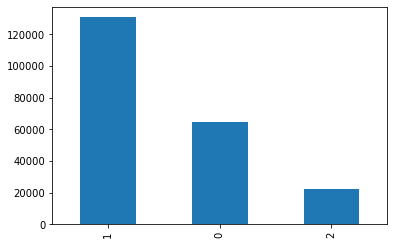

In [6]:
np.random.seed(2604)
n = len(coAuthorshipGraph.nodes())
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]
#setting the classes
df = pd.concat([df_train,df_test])
conditions = [(df["hindex"] == 1),
              (df["hindex"] > 1) & (df["hindex"] <= 20),
              (df["hindex"] > 20)]
val = [0, 1, 2]
df[ "hindex_label"] = np.select(conditions, val)
labels = pd.Series(data=df["hindex_label"].to_numpy(), index = df["author"].to_numpy())
labels.value_counts().plot(kind='bar')

In [7]:
a = labels.value_counts().to_numpy()
#we can see here how unbalanced the dataset is
print(a/np.sum(a))

[0.60046097 0.29588478 0.10365425]


In [12]:
labels = torch.from_numpy(labels.to_numpy())

In [14]:
idx_train_0 = []
idx_train_1 = []
idx_train_2 = []
counting = {0:0,1:0,2:0}
for i in idx_train:
    lab = labels[i].item()
    if lab == 0:
        idx_train_0.append(i)
    if lab == 1:
        idx_train_1.append(i)
    if lab == 2:
        idx_train_2.append(i)
number_2 = len(idx_train_2)
idx_train_0 = idx_train_0[:number_2]
idx_train_1 = idx_train_1[:number_2]
new_idx_train = np.concatenate([idx_train_0,idx_train_1,idx_train_2])
np.random.shuffle(new_idx_train)

In [15]:
class_labels_train = labels[new_idx_train]
class_labels_validation = labels[idx_val]
class_labels_test = labels[idx_test]

# GCN

In [16]:
def normalise_adjacency(A):
    #Please insert your code for Task 4 here
    n = A.shape[0]
    A_with_self_loops = A + sp.identity(n)
    
    degrees = A.sum(axis=0) + 1
    inv_degrees = np.power(degrees, -0.5)
    D_inv = sp.diags(np.squeeze(np.asarray((inv_degrees))))
    
    A_normalised = D_inv @ A_with_self_loops @ D_inv 

    return A_normalised



def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


class GCN(nn.Module):
    """Simple GCN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GCN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        
        #Please insert your code for Task 5 here
        
        x = self.fc1(x_in)
        x = self.relu(torch.mm(adj, x))
        x = self.dropout(x)

        x = self.fc2(x)
        t = self.relu(torch.mm(adj, x))
        
        x = self.fc3(t)

        return F.log_softmax(x, dim=1), t

In [17]:
node_to_id_train = {}
node_to_id_test = {}
for i, row in tq.tqdm(df_train.iterrows()):
    node_to_id_train[int(row['author'])] = i
    
for i, row in tq.tqdm(df_test.iterrows()):
    node_to_id_test[int(row['author'])] = i

In [18]:
x_test_fill = x_test_complete.to_numpy()
x_train_fill = x_train_complete.to_numpy()
X = []
for node in tq.tqdm(list(coAuthorshipGraph.nodes)):
    if node in node_to_id_train:
        X.append(x_train_fill[node_to_id_train[node]])
    elif node in node_to_id_test:
        X.append(x_test_fill[node_to_id_test[node]])
        
X = np.array(X)
X = torch.from_numpy(X)
X = X.float()

In [19]:
# Hyperparameters
epochs = 50
n_hidden_1 = 256
n_hidden_2 = 128
learning_rate = 0.01
dropout_rate = 0.5
n_class = 3

# Creates the model and specifies the optimizer
model = GCN(X.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

adj = normalise_adjacency(sp.csr_matrix(nx.adjacency_matrix(coAuthorshipGraph))) 
adj = sparse_to_torch_sparse(adj)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(X, adj)
    loss_train = F.nll_loss(output[new_idx_train], class_labels_train)
    acc_train = accuracy_score(torch.argmax(output[new_idx_train], dim=1).detach().cpu().numpy(), class_labels_train.cpu().numpy())
    loss_train.backward()
    optimizer.step()

    
    model.eval()
    output,_ = model(X, adj)

    loss_val = F.nll_loss(output[idx_val], class_labels_validation)
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), class_labels_validation.cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(X, adj)
    loss_test = F.nll_loss(output[idx_test], class_labels_test)
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), class_labels_test.cpu().numpy())
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings

# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
GCN_embeddings = test()

Epoch: 001 loss_train: 19.8464 acc_train: 0.2887 loss_val: 127.7433 acc_val: 0.1032 time: 7.5058s
Epoch: 002 loss_train: 79.4149 acc_train: 0.3333 loss_val: 54.1696 acc_val: 0.6307 time: 6.2022s
Epoch: 003 loss_train: 146.4910 acc_train: 0.3696 loss_val: 42.5776 acc_val: 0.6250 time: 5.9208s
Epoch: 004 loss_train: 115.3664 acc_train: 0.4938 loss_val: 19.0940 acc_val: 0.3853 time: 6.1598s
Epoch: 005 loss_train: 46.7675 acc_train: 0.3974 loss_val: 47.6758 acc_val: 0.3136 time: 5.9865s
Epoch: 006 loss_train: 30.4696 acc_train: 0.4019 loss_val: 56.7218 acc_val: 0.2419 time: 5.7980s
Epoch: 007 loss_train: 35.3357 acc_train: 0.3401 loss_val: 33.7986 acc_val: 0.4915 time: 5.9244s
Epoch: 008 loss_train: 22.0545 acc_train: 0.3353 loss_val: 4.5276 acc_val: 0.5768 time: 5.7324s
Epoch: 009 loss_train: 4.9204 acc_train: 0.3315 loss_val: 4.3536 acc_val: 0.5216 time: 5.9378s
Epoch: 010 loss_train: 9.8692 acc_train: 0.3296 loss_val: 4.7310 acc_val: 0.2874 time: 6.0618s
Epoch: 011 loss_train: 11.0130 a

In [20]:
preds = torch.argmax(model(X, adj)[0], dim=1).detach().cpu().numpy()

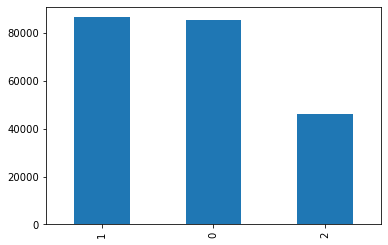

In [21]:
pd.Series(preds).value_counts().plot(kind='bar')